In [1]:
import pandas as pd
import numpy as np
import yaml
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from catboost import CatBoostRegressor, Pool, EFeaturesSelectionAlgorithm
from collections import Counter
import optuna
import warnings
import pickle
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Ä–∞—Å—á–µ—Ç–∞ WAPE (Weighted Absolute Percentage Error)
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [3]:
df = pd.read_csv('–¥–ª—è –º–æ–¥–µ–ª–∏ v7.csv', parse_dates=['report_date'])

In [4]:
target_ = 'target_cost'

In [5]:
cat = df.copy()
cat.shape
# –æ—Å—Ç–∞–≤–ª—è–µ–º —Å –Ω–µ–ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–º–∏ —Ç–∞—Ä–≥–µ—Ç–æ–º
cat=cat[cat[target_].notnull()]
cat.shape[0]

7087

In [6]:
def split_train_oot(data):
    # –ù–∞—Ö–æ–¥–∏–º —Å–∞–º—É—é –ø–æ–∑–¥–Ω—é—é –¥–∞—Ç—É –≤ –¥–∞–Ω–Ω—ã—Ö
    latest_date = data['report_date'].max()

    # –í—ã—á–∏—Å–ª—è–µ–º –¥–∞—Ç—É, –∫–æ—Ç–æ—Ä–∞—è –±—ã–ª–∞ —Ç—Ä–∏ –º–µ—Å—è—Ü–∞ –Ω–∞–∑–∞–¥ –æ—Ç —Å–∞–º–æ–π –ø–æ–∑–¥–Ω–µ–π –¥–∞—Ç—ã
    three_months_ago = latest_date - pd.DateOffset(months=3)

    # –û—Ç–±–∏—Ä–∞–µ–º —Å—Ç—Ä–æ–∫–∏, –≥–¥–µ report_date –ø–æ–ø–∞–¥–∞–µ—Ç –≤ –ø–æ—Å–ª–µ–¥–Ω–∏–µ —Ç—Ä–∏ –º–µ—Å—è—Ü–∞
    data.loc[data['report_date'] >= three_months_ago, 'split_type'] = 'oot'

    # –¢–µ–ø–µ—Ä—å –∑–∞–ø–æ–ª–Ω–∏–º NaN –∑–Ω–∞—á–µ–Ω–∏—è –≤ —Å—Ç–æ–ª–±—Ü–µ 'split_type' –∑–Ω–∞—á–µ–Ω–∏–µ–º 'train'
    data.loc[data['split_type'].isna(), 'split_type'] = 'train'
    return data

In [7]:
# –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Ä–∞—Å—á–µ—Ç–∞ –≤—Å–µ—Ö –º–µ—Ç—Ä–∏–∫
def calculate_metrics(y_true, y_pred, dataset_name):
    return {
        'dataset': dataset_name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'WAPE': wape(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'mean_target': y_true.mean(),
        'mean_pred': y_pred.mean(),
        'n_samples': len(y_true)
    }

In [8]:
def shap_gr(name_model, values):# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è SHAP
    explainer = shap.TreeExplainer(name_model)
    shap_values = explainer.shap_values(values)

    # –°–æ–∑–¥–∞–µ–º —Ñ–∏–≥—É—Ä—É —Å —Ä–µ–≥—É–ª–∏—Ä—É–µ–º—ã–º –º–µ—Å—Ç–æ–º –¥–ª—è —à–∫–∞–ª—ã
    plt.figure(figsize=(16, 8))

    ax1 = plt.axes([0.1, 0.1, 0.7, 0.8])  
    shap.summary_plot(shap_values, values,
                    max_display=20,
                    plot_type="dot",
                    color=plt.get_cmap("coolwarm"),
                    show=False,
                    plot_size=None)

    # –ù–∞—Å—Ç—Ä–æ–π–∫–∏ –≥—Ä–∞—Ñ–∏–∫–∞
    ax1.set_title("–í–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ SHAP –∑–Ω–∞—á–µ–Ω–∏—è–º", fontsize=14, pad=20)
    ax1.set_xlabel("–í–ª–∏—è–Ω–∏–µ –Ω–∞ –≤—ã—Ö–æ–¥ –º–æ–¥–µ–ª–∏ (SHAP value)", fontsize=12)
    ax1.set_ylabel("–ü—Ä–∏–∑–Ω–∞–∫–∏", fontsize=12)
    ax1.tick_params(labelsize=10)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    plt.show()

In [9]:
cat = split_train_oot(cat)

# –ú–æ–¥–µ–ª—å

# –¢–µ—Å—Ç 1

In [11]:
drop_cols = [
    'split_type', 
    'smt_building_addressid', 
    'sales__g_building__smt_projected_total_area__sum__1M', 
    'cost_net__g_building__sale_cost__sum__1M', 
    'report_date',
    'target_area', 
    target_
] 


In [12]:
# –†–∞–∑–¥–µ–ª—è–µ–º –¥–∞–Ω–Ω—ã–µ
train_data = cat[cat['split_type'] == 'train']
test_data = cat[cat['split_type'] == 'oot']

# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
X_train = train_data.drop(columns=drop_cols)
y_train = train_data[target_]

X_test = test_data.drop(columns=drop_cols)
y_test = test_data[target_]

# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –∏ –æ–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
model = CatBoostRegressor(
    iterations=2000,
    depth=8,
    learning_rate=0.1,
    loss_function='MAE',
    l2_leaf_reg=3,
    random_strength=1,
    early_stopping_rounds=100,
    verbose=0
)
model.fit(X_train, y_train)

# –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)


# –°–æ–∑–¥–∞–µ–º DataFrame —Å –º–µ—Ç—Ä–∏–∫–∞–º–∏
metrics_df = pd.DataFrame([
    calculate_metrics(y_train, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
metrics_df_base = metrics_df

In [13]:
metrics_df_base

dataset           MAE           MSE          RMSE      MAPE      WAPE  \
0   train   1865.386966  3.186300e+07   5644.731817  0.010823  0.010046   
1    test  19883.296825  8.057114e+08  28385.056469  0.098025  0.098353   

         R2    mean_target      mean_pred  n_samples  
0  0.987548  185685.752829  185366.093812       5958  
1  0.770408  202162.258782  204964.810006       1129

# –û—Ç–±–æ—Ä —Ñ–∏—á

In [14]:
cat = df.copy()
cat.shape
# –æ—Å—Ç–∞–≤–ª—è–µ–º —Å –Ω–µ–ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–º–∏ —Ç–∞—Ä–≥–µ—Ç–æ–º
cat=cat[cat[target_].notnull()]
cat.shape[0]

7087

In [15]:
cat = split_train_oot(cat)

In [16]:
# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö
cat['report_date'] = pd.to_datetime(cat['report_date'])
cat['year_month'] = cat['report_date'].dt.to_period('M').astype(str)

# –£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –ø–æ –≤—Ä–µ–º–µ–Ω–∏ –≤ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–π –≤—ã–±–æ—Ä–∫–µ
train_df = cat[cat['split_type'] == 'train'].copy()

feature_columns = [col for col in cat.columns if col not in drop_cols]

# –°–ø–∏—Å–æ–∫ –¥–ª—è —Å–±–æ—Ä–∞ –≤—ã–±—Ä–∞–Ω–Ω—ã—Ö —Ñ–∏—á –∏ –º–µ—Ç—Ä–∏–∫
features_across_splits = []
metrics_across_splits = []

# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# –°–æ—Ä—Ç–∏—Ä—É–µ–º –¥–∞–Ω–Ω—ã–µ –ø–æ –¥–∞—Ç–µ –¥–ª—è –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ–≥–æ —Ä–∞–∑–±–∏–µ–Ω–∏—è
train_df = train_df.sort_values('report_date')

for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_split = train_df.iloc[train_index]
    val_split = train_df.iloc[val_index]
    
    train_dates = train_split['report_date'].min(), train_split['report_date'].max()
    val_dates = val_split['report_date'].min(), val_split['report_date'].max()
    
    print(f"\nüîπ –°–ø–ª–∏—Ç {fold}: train = {train_dates[0]} - {train_dates[1]}, val = {val_dates[0]} - {val_dates[1]}")
    
    # –°–æ–∑–¥–∞–Ω–∏–µ Pool –æ–±—ä–µ–∫—Ç–æ–≤
    train_pool = Pool(
        data=train_split[feature_columns],
        label=train_split[target_],
        cat_features=['year_month']
    )
    
    val_pool = Pool(
        data=val_split[feature_columns],
        label=val_split[target_],
        cat_features=['year_month']
    )

    # –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –º–æ–¥–µ–ª–∏
    model = CatBoostRegressor(
        iterations=1000,
        depth=6,
        learning_rate=0.05,
        loss_function='MAE',
        verbose=False,
        grow_policy='Lossguide'
    )
    # –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
    model.fit(train_pool, eval_set=val_pool)
    
    # –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –∏ –º–µ—Ç—Ä–∏–∫–∏
    y_train_pred = model.predict(train_pool)
    y_val_pred = model.predict(val_pool)
    
    # –†–∞—Å—á–µ—Ç –º–µ—Ç—Ä–∏–∫ –¥–ª—è train
    train_metrics = {
        'split': f'fold_{fold}_train',
        'start_date': train_dates[0],
        'end_date': train_dates[1],
        'n_samples': len(train_split),
        'mean_target': train_split[target_].mean(),
        'mean_pred': y_train_pred.mean(),
        'mae': mean_absolute_error(train_split[target_], y_train_pred),
        'rmse': np.sqrt(mean_squared_error(train_split[target_], y_train_pred)),
        'mape': mean_absolute_percentage_error(train_split[target_], y_train_pred),
        'wape': wape(train_split[target_], y_train_pred),
        'r2': r2_score(train_split[target_], y_train_pred)
    }
    
    # –†–∞—Å—á–µ—Ç –º–µ—Ç—Ä–∏–∫ –¥–ª—è validation
    val_metrics = {
        'split': f'fold_{fold}_val',
        'start_date': val_dates[0],
        'end_date': val_dates[1],
        'n_samples': len(val_split),
        'mean_target': val_split[target_].mean(),
        'mean_pred': y_val_pred.mean(),
        'mae': mean_absolute_error(val_split[target_], y_val_pred),
        'rmse': np.sqrt(mean_squared_error(val_split[target_], y_val_pred)),
        'mape': mean_absolute_percentage_error(val_split[target_], y_val_pred),
        'wape': wape(val_split[target_], y_val_pred),
        'r2': r2_score(val_split[target_], y_val_pred)
    }
    
    metrics_across_splits.extend([train_metrics, val_metrics])
    
    # –û—Ç–±–æ—Ä —Ñ–∏—á–µ–π
    selected_features = model.select_features(
        train_pool,
        eval_set=val_pool,
        features_for_select=feature_columns,
        num_features_to_select=100,
        steps=2,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        train_final_model=False,
        verbose=False
    )
    
    selected_features_names = [feature_columns[i] for i in selected_features['selected_features']]
    print(f" –û—Ç–æ–±—Ä–∞–Ω–æ —Ñ–∏—á–µ–π: {len(selected_features_names)}")
    features_across_splits.extend(selected_features_names)

# –°–æ–∑–¥–∞–µ–º DataFrame —Å –º–µ—Ç—Ä–∏–∫–∞–º–∏
metrics_df = pd.DataFrame(metrics_across_splits)

# –§–æ—Ä–º–∞—Ç–∏—Ä—É–µ–º –¥–∞—Ç—ã 
metrics_df['start_date'] = metrics_df['start_date'].dt.strftime('%Y-%m-%d')
metrics_df['end_date'] = metrics_df['end_date'].dt.strftime('%Y-%m-%d')

# –ü–µ—Ä–µ—É–ø–æ—Ä—è–¥–æ—á–∏–≤–∞–µ–º —Å—Ç–æ–ª–±—Ü—ã
cols_order = ['split', 'start_date', 'end_date', 'n_samples', 'mean_target', 'mean_pred',
              'mae', 'rmse', 'mape', 'wape','r2']
metrics_df_select_features = metrics_df[cols_order]

# –ê–Ω–∞–ª–∏–∑ —Ñ–∏—á–µ–π
feature_counts = Counter(features_across_splits)
final_features = [f for f, count in feature_counts.items() if count >= 2]

print("\n –ò—Ç–æ–≥–æ–≤—ã–µ —É—Å—Ç–æ–π—á–∏–≤—ã–µ —Ñ–∏—á–∏ (–≤—Å—Ç—Ä–µ—á–∞–ª–∏—Å—å >= 2 —Ä–∞–∑):")
print("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ:", len(final_features))



üîπ –°–ø–ª–∏—Ç 1: train = 2022-03-01 00:00:00 - 2022-09-01 00:00:00, val = 2022-09-01 00:00:00 - 2023-03-01 00:00:00
Step #1 out of 2

bestTest = 18824.23614
bestIteration = 87

Shrink model to first 88 iterations.
Feature #585 eliminated
Feature #556 eliminated
Feature #571 eliminated
Feature #612 eliminated
Feature #528 eliminated
Feature #650 eliminated
Feature #760 eliminated
Feature #681 eliminated
Feature #626 eliminated
Feature #610 eliminated
Feature #535 eliminated
Feature #691 eliminated
Feature #598 eliminated
Feature #254 eliminated
Feature #550 eliminated
Feature #127 eliminated
Feature #290 eliminated
Feature #555 eliminated
Feature #858 eliminated
Feature #217 eliminated
Feature #831 eliminated
Feature #742 eliminated
Feature #564 eliminated
Feature #635 eliminated
Feature #629 eliminated
Feature #300 eliminated
Feature #833 eliminated
Feature #134 eliminated
Feature #845 eliminated
Feature #442 eliminated
Feature #638 eliminated
Feature #597 eliminated
Feature #439 el

In [17]:
metrics_df_select_features

split  start_date    end_date  n_samples    mean_target  \
0  fold_1_train  2022-03-01  2022-09-01        993  180561.158820   
1    fold_1_val  2022-09-01  2023-03-01        993  172763.010786   
2  fold_2_train  2022-03-01  2023-03-01       1986  176662.084803   
3    fold_2_val  2023-03-01  2023-08-01        993  176531.040187   
4  fold_3_train  2022-03-01  2023-08-01       2979  176618.403264   
5    fold_3_val  2023-08-01  2023-12-01        993  185026.132325   
6  fold_4_train  2022-03-01  2023-12-01       3972  178720.335529   
7    fold_4_val  2023-12-01  2024-03-01        993  197849.984250   
8  fold_5_train  2022-03-01  2024-03-01       4965  182546.265274   
9    fold_5_val  2024-03-01  2024-06-01        993  201383.190606   

       mean_pred           mae          rmse      mape      wape        r2  
0  179618.570276   7127.649658  13640.834859  0.038774  0.039475  0.922103  
1  184587.418307  18668.817334  25220.828660  0.117008  0.108060  0.654353  
2  176381.493583   5666.460275  12255.217873  0.033532  0.032075  0.929478  
3  171249.714494  14120.772765  20893.659348  0.077769  0.079990  0.756194  
4  176511.665079   4986.092969  11316.799918  0.029779  0.028231  0.936494  
5  181051.342282  12274.705732  19705.638693  0.062626  0.066340  0.809913  
6  178394.279862   5124.586511  11757.913757  0.029365  0.028674  0.932113  
7  190141.961919  14954.819809  28315.994751  0.067734  0.075587  0.752650  
8  182009.802828   5862.081789  14218.232647  0.032144  0.032113  0.913460  
9  200403.884770  13019.503167  21464.280091  0.061527  0.064650  0.863600

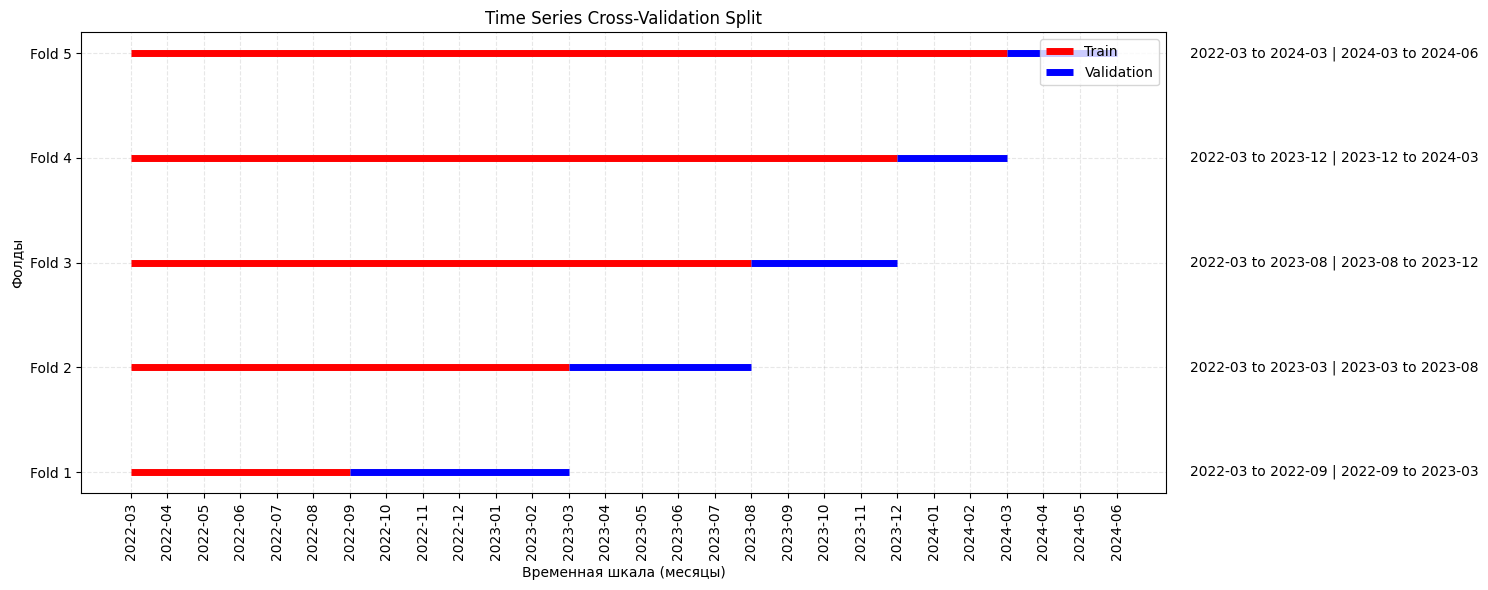

In [18]:
plt.figure(figsize=(15, 6))

# –ü–æ–ª—É—á–∞–µ–º –≤—Å–µ —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –¥–∞—Ç—ã
all_dates = np.sort(train_df['report_date'].unique())
date_labels = [str(date)[:7] for date in all_dates]  # –§–æ—Ä–º–∞—Ç YYYY-MM

# –¶–≤–µ—Ç–∞ –¥–ª—è train/val
train_color = 'red'
val_color = 'blue'

for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_dates = train_df.iloc[train_index]['report_date'].unique()
    val_dates = train_df.iloc[val_index]['report_date'].unique()
    
    # –ù–∞—Ö–æ–¥–∏–º –∏–Ω–¥–µ–∫—Å—ã –¥–∞—Ç
    train_idx = [np.where(all_dates == d)[0][0] for d in train_dates]
    val_idx = [np.where(all_dates == d)[0][0] for d in val_dates]
    
    # –†–∏—Å—É–µ–º –ª–∏–Ω–∏–∏
    plt.hlines(y=fold, xmin=min(train_idx), xmax=max(train_idx), 
              color=train_color, linewidth=5, label='Train' if fold == 1 else "")
    plt.hlines(y=fold, xmin=min(val_idx), xmax=max(val_idx), 
              color=val_color, linewidth=5, label='Validation' if fold == 1 else "")

# –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –≥—Ä–∞—Ñ–∏–∫–∞
plt.yticks(range(1, tscv.n_splits+1), [f'Fold {i}' for i in range(1, tscv.n_splits+1)])
plt.xticks(range(len(all_dates)), date_labels, rotation=90)
plt.title('Time Series Cross-Validation Split')
plt.xlabel('–í—Ä–µ–º–µ–Ω–Ω–∞—è —à–∫–∞–ª–∞ (–º–µ—Å—è—Ü—ã)')
plt.ylabel('–§–æ–ª–¥—ã')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='upper right')

# –î–æ–±–∞–≤–∏–º –ø–æ–¥–ø–∏—Å–∏ –¥–∞—Ç –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —Ñ–æ–ª–¥–∞
for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_dates = train_df.iloc[train_index]['report_date'].unique()
    val_dates = train_df.iloc[val_index]['report_date'].unique()
    
    plt.text(x=len(all_dates)+1, y=fold, 
             s=f"{train_dates[0].strftime('%Y-%m')} to {train_dates[-1].strftime('%Y-%m')} | {val_dates[0].strftime('%Y-%m')} to {val_dates[-1].strftime('%Y-%m')}",
             ha='left', va='center')

plt.tight_layout()
plt.show()

In [19]:
filtered_df = cat[list(set(cat.columns) & set(final_features))]
filtered_df.head(3)

rosstat_q__g_rd__num_mortgage_loans_resident__avg__1_4Q  \
11                                         110572.164         
12                                         110572.164         
13                                         110572.164         

    area__g_building__smt_projected_total_area__rooms_3plus_free__count  \
11                                                NaN                     
12                                               86.0                     
13                                               87.0                     

    expon_cost__g_building__pc_cost_diff__rooms_0__min__1M  \
11                                                NaN        
12                                             5265.0        
13                                           -10390.0        

    expon_cost__g_building__pc_cost_diff__avg__1_4M  \
11                                           1370.0   
12                                           1370.0   
13                                           5265.0   

    expon_cost__g_building__pc_cost_diff__rooms_2__max__12M  \
11                                                NaN         
12                                                NaN         
13                                            -7652.0         

    floor__g_building__smt_floor__rooms_2__avg  \
11                                    9.197803   
12                                    9.197803   
13                                    9.197803   

    sales__g_building__sale_price__rooms_0__sum__1_600M  \
11                                                NaN     
12                                                NaN     
13                                         13523355.0     

    expon_cost__g_building__pc_cost_diff_rel__rooms_1__max__12M  \
11                                                NaN             
12                                                NaN             
13                                          -0.049997             

    expon_cost__g_building__pc_cost_diff__rooms_0__avg__1M  \
11                                                NaN        
12                                           5265.000        
13                                         -10015.655        

    mortgages__g_building__smt_loan_period__avg__1_600M  ...  \
11                                                NaN    ...   
12                                          360.40000    ...   
13                                          341.82144    ...   

    area__g_building__smt_projected_total_area__str_r__sum  \
11                                                0.0        
12                                            25124.1        
13                                            21433.5        

    expon_cost__g_building__pc_cost_diff_rel__rooms_3plus__min__3M  \
11                                                NaN                
12                                                NaN                
13                                          -0.050003                

    expon_cost__g_building__pc_cost_diff__min__3M  \
11                                         1370.0   
12                                         5265.0   
13                                       -10390.0   

    expon_cost__g_building__pc_cost__rooms_1__max__1M  \
11                                                0.0   
12                                           176755.0   
13                                           176755.0   

    expon_cost__g_building__pc_cost_diff_rel__rooms_2__max__3M  \
11                                                NaN            
12                                                NaN            
13                                          -0.049997            

    sales__g_building__sale_cost__rooms_0__min__1_600M  \
11                                                NaN    
12                                                NaN    
13                                          178095.02    

    rosstat_m__g_rd__overdue_debt_loans_resi

In [20]:
# –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ —Å—Ç–æ–ª–±—Ü–æ–≤
numeric_cols =filtered_df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = filtered_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("–ß–∏—Å–ª–æ–≤—ã–µ —Å—Ç–æ–ª–±—Ü—ã:", numeric_cols)
print("–ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ —Å—Ç–æ–ª–±—Ü—ã:", categorical_cols)

–ß–∏—Å–ª–æ–≤—ã–µ —Å—Ç–æ–ª–±—Ü—ã: ['rosstat_q__g_rd__num_mortgage_loans_resident__avg__1_4Q', 'area__g_building__smt_projected_total_area__rooms_3plus_free__count', 'expon_cost__g_building__pc_cost_diff__rooms_0__min__1M', 'expon_cost__g_building__pc_cost_diff__avg__1_4M', 'expon_cost__g_building__pc_cost_diff__rooms_2__max__12M', 'floor__g_building__smt_floor__rooms_2__avg', 'sales__g_building__sale_price__rooms_0__sum__1_600M', 'expon_cost__g_building__pc_cost_diff_rel__rooms_1__max__12M', 'expon_cost__g_building__pc_cost_diff__rooms_0__avg__1M', 'mortgages__g_building__smt_loan_period__avg__1_600M', 'mortgages__g_building__required_amount__min__1M', 'expon_cost__g_building__pc_cost_diff__min__12M', 'reservations__g_building__min_reservation_date__max', 'mortgages__g_building__loan_amount__max__6M', 'floor__g_building__smt_floor__rooms_1__avg', 'mortgages__g_building__initial_fee__avg__3M', 'area__g_building__smt_projected_total_area__avg', 'expon_cost__g_building__pc_cost_diff_rel__r

In [21]:
# –°–æ–∑–¥–∞–µ–º —Å–ª–æ–≤–∞—Ä—å –¥–ª—è YAML
data = {
    'numeric_columns': numeric_cols,
    'categorical_columns': categorical_cols,
    'id': ['smt_building_addressid'],
    'date' : ['report_date'],
    'target' : [target_]
}

# –ó–∞–ø–∏—Å—ã–≤–∞–µ–º –≤ YAML-—Ñ–∞–π–ª
with open('features_model_cost.yml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False, sort_keys=False)

In [22]:
# –∑–∞–≥—Ä—É–∑–∏–º —Ñ–∏—á–∏
with open('features_model_cost.yml', 'r') as file:
    config = yaml.safe_load(file)

# 2. –ò–∑–≤–ª–µ—á–µ–Ω–∏–µ —Å–ø–∏—Å–∫–æ–≤ —Å—Ç–æ–ª–±—Ü–æ–≤
numeric_cols = config.get('numeric_columns', [])
target_cols = config.get('target', [])
id_col = config.get('id', [])
date_col = config.get('date', [])
all_config_columns = numeric_cols + categorical_cols+id_col+date_col+target_cols

In [23]:
filtered_df = cat[list(set(cat.columns) & set(all_config_columns))].reset_index(drop=True)
filtered_df.head(5)

rosstat_q__g_rd__num_mortgage_loans_resident__avg__1_4Q  \
0                                         110572.164         
1                                         110572.164         
2                                         110572.164         
3                                         106712.800         
4                                         106712.800         

   area__g_building__smt_projected_total_area__rooms_3plus_free__count  \
0                                                NaN                     
1                                               86.0                     
2                                               87.0                     
3                                               86.0                     
4                                               87.0                     

   expon_cost__g_building__pc_cost_diff__rooms_0__min__1M  \
0                                                NaN        
1                                            5265.00        
2                                          -10390.00        
3                                               0.01        
4                                            5654.00        

   expon_cost__g_building__pc_cost_diff__avg__1_4M  \
0                                        1370.0000   
1                                        1370.0000   
2                                        5265.0000   
3                                       -8682.2950   
4                                       -1678.4677   

   expon_cost__g_building__pc_cost_diff__rooms_2__max__12M  \
0                                                NaN         
1                                                NaN         
2                                           -7652.00         
3                                            5131.99         
4                                            5301.00         

   floor__g_building__smt_floor__rooms_2__avg  \
0                                    9.197803   
1                                    9.197803   
2                                    9.197803   
3                                    9.197803   
4                                    9.197803   

   sales__g_building__sale_price__rooms_0__sum__1_600M  \
0                                                NaN     
1                                                NaN     
2                                         13523355.0     
3                                         57686668.0     
4                                        117890730.0     

   expon_cost__g_building__pc_cost_diff_rel__rooms_1__max__12M  \
0                                                NaN             
1                                                NaN             
2                                          -0.049997             
3                                           0.030000             
4                                           0.030005             

   expon_cost__g_building__pc_cost_diff__rooms_0__avg__1M  \
0                                                NaN        
1                                          5265.0000        
2                                        -10015.6550        
3                                           943.5466        
4                                          5750.4443        

   mortgages__g_building__smt_loan_period__avg__1_600M  ...  \
0                                                NaN    ...   
1                                          360.40000    ...   
2                                          341.82144    ...   
3                                          337.24518    ...   
4                                          337.57996    ...   

   area__g_building__smt_projected_total_area__str_r__sum  \
0                                                0.0        
1                                            25124.1        
2                                            21433.5        
3                                            18036.5        
4                           

In [24]:
filtered_df = split_train_oot(filtered_df)

# –ú–æ–¥–µ–ª—å 2 –Ω–∞ –≤—ã–±—Ä–∞–Ω–Ω—ã—Ö —Ñ–∏—á–∞—Ö

In [25]:
# –†–∞–∑–¥–µ–ª–∏–º –¥–∞–Ω–Ω—ã–µ –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–µ –∏ —Ç–µ—Å—Ç–æ–≤—ã–µ
train_data = filtered_df[filtered_df['split_type'] == 'train']
test_data = filtered_df[filtered_df['split_type'] == 'oot']

# –í—ã–±–µ—Ä–∏—Ç–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ (features) –∏ —Ü–µ–ª–µ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é (target)
# –î–æ–ø—É—Å—Ç–∏–º, —É –≤–∞—Å –µ—Å—Ç—å —Å—Ç–æ–ª–±–µ—Ü 'target', –∫–æ—Ç–æ—Ä—ã–π –Ω—É–∂–Ω–æ –ø—Ä–µ–¥—Å–∫–∞–∑–∞—Ç—å
X_train = train_data.drop(columns=['split_type','smt_building_addressid', 'report_date',
                     target_])  
y_train = train_data[target_]

X_test = test_data.drop(columns=['split_type', 'smt_building_addressid', 'report_date',
                         target_])  
y_test = test_data[target_]

# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∏—Ä—É–µ–º –º–æ–¥–µ–ª—å 
model = CatBoostRegressor(
                    iterations=2000,  
                    depth=8,         
                    learning_rate=0.1,  # –£–º–µ–Ω—å—à–∞–µ–º learning rate
                    loss_function='MAE',  
                    l2_leaf_reg=3,   
                    random_strength=1,
                    early_stopping_rounds=100,  # –†–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞
                    verbose=200,
                    grow_policy='Lossguide'  # –ê–ª—å—Ç–µ—Ä–Ω–∞—Ç–∏–≤–Ω–∞—è —Å—Ç—Ä–∞—Ç–µ–≥–∏—è —Ä–æ—Å—Ç–∞
                )
# –û–±—É—á–∞–µ–º –º–æ–¥–µ–ª—å –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö
model.fit(X_train, y_train)

# –î–µ–ª–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è 
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# –°–æ–∑–¥–∞–µ–º DataFrame —Å –º–µ—Ç—Ä–∏–∫–∞–º–∏
metrics_df = pd.DataFrame([
    calculate_metrics(y_train, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
metrics_df_with_select_features = metrics_df

0:	learn: 34172.3577870	total: 6.74ms	remaining: 13.5s
200:	learn: 7581.1995457	total: 1.59s	remaining: 14.3s
400:	learn: 6292.3129976	total: 3.31s	remaining: 13.2s
600:	learn: 5624.8534767	total: 4.95s	remaining: 11.5s
800:	learn: 5225.4362348	total: 6.59s	remaining: 9.86s
1000:	learn: 4929.2483897	total: 8.22s	remaining: 8.21s
1200:	learn: 4690.8169001	total: 9.82s	remaining: 6.54s
1400:	learn: 4512.6249595	total: 11.4s	remaining: 4.89s
1600:	learn: 4361.2242671	total: 13s	remaining: 3.25s
1800:	learn: 4225.0329559	total: 14.7s	remaining: 1.62s
1999:	learn: 4108.4492912	total: 16.3s	remaining: 0us


In [26]:
metrics_df_with_select_features

dataset           MAE           MSE          RMSE      MAPE      WAPE  \
0   train   4108.449239  1.171805e+08  10824.993241  0.023166  0.022126   
1    test  19813.401604  7.365610e+08  27139.657440  0.102124  0.098007   

         R2    mean_target      mean_pred  n_samples  
0  0.954207  185685.752829  185473.345168       5958  
1  0.790112  202162.258782  211229.126685       1129

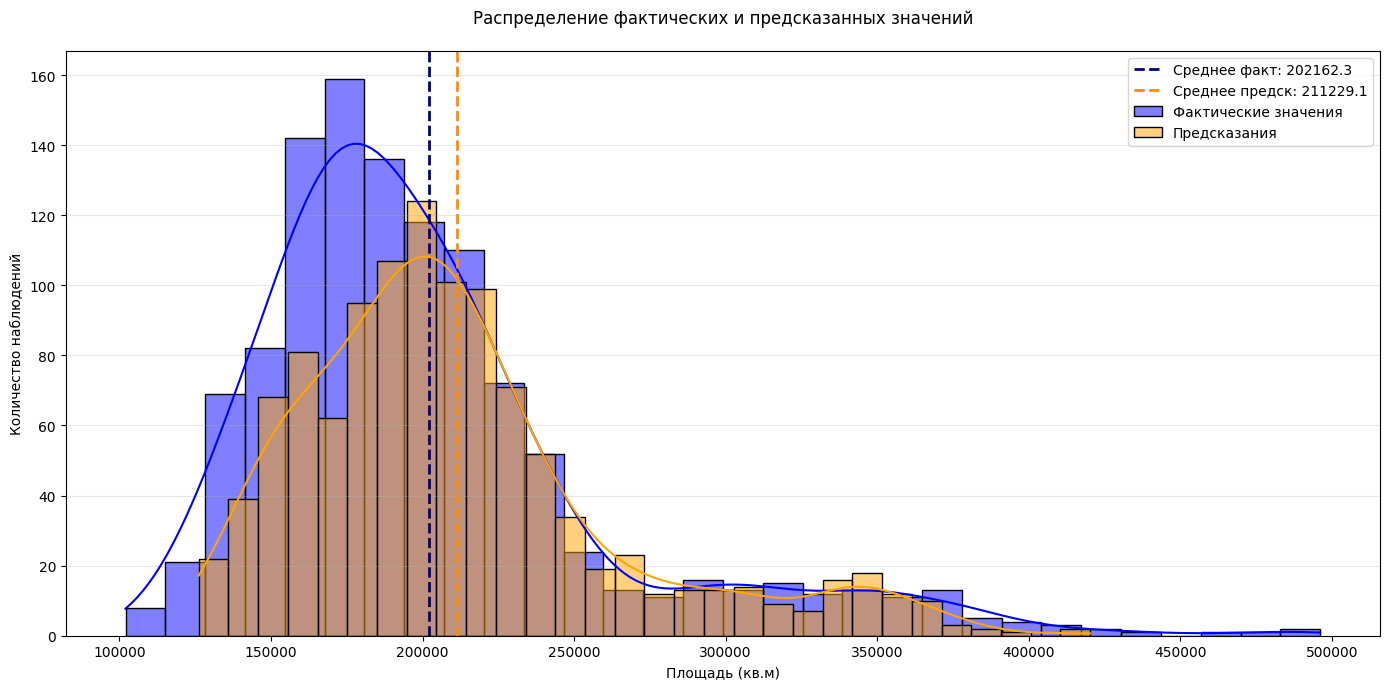

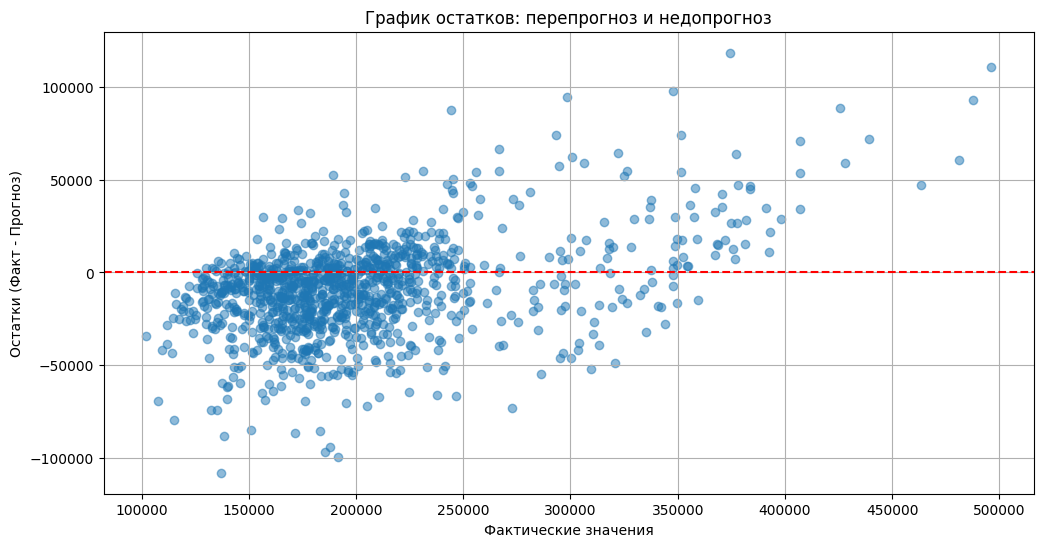

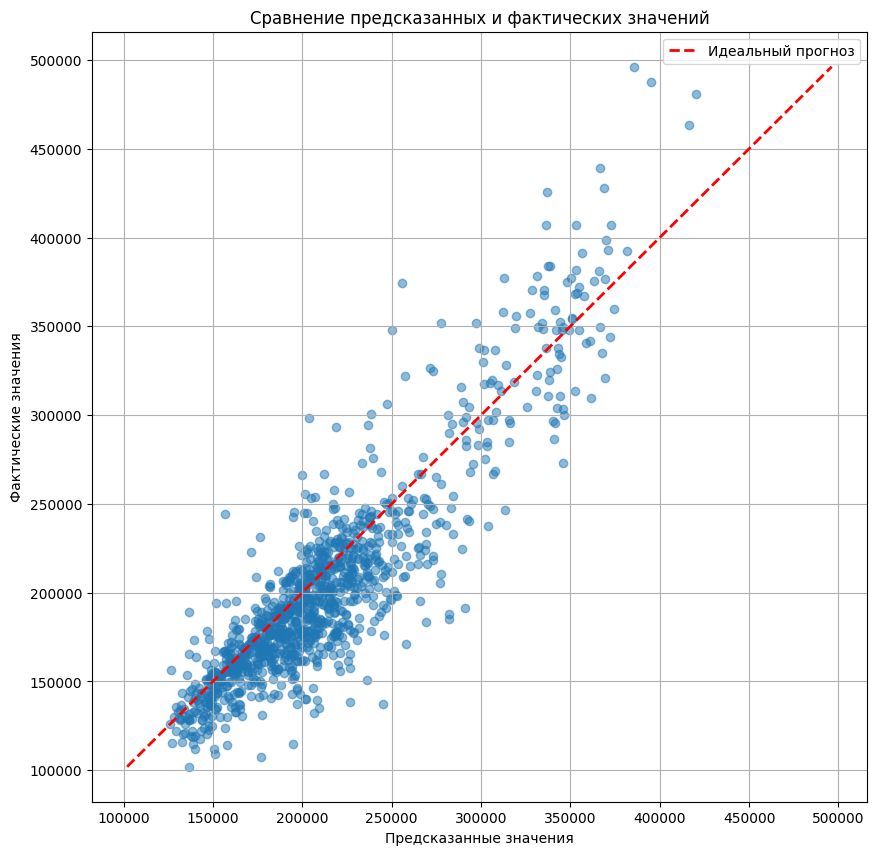

In [27]:
# 1. –ê–Ω–∞–ª–∏–∑ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ç–∞—Ä–≥–µ—Ç–∞ –∏ –ø—Ä–µ–¥–∏–∫—Ç–æ–≤
plt.figure(figsize=(14, 7))

# –ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ —Å –Ω–∞–ª–æ–∂–µ–Ω–∏–µ–º KDE
ax = sns.histplot(y_test, bins=30, color='blue', alpha=0.5, label='–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è', kde=True)
sns.histplot(test_pred, bins=30, color='orange', alpha=0.5, label='–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è', kde=True, ax=ax)

# –î–æ–±–∞–≤–ª—è–µ–º –ª–∏–Ω–∏–∏ —Å—Ä–µ–¥–Ω–∏—Ö
plt.axvline(y_test.mean(), color='navy', linestyle='--', linewidth=2, label=f'–°—Ä–µ–¥–Ω–µ–µ —Ñ–∞–∫—Ç: {y_test.mean():.1f}')
plt.axvline(test_pred.mean(), color='darkorange', linestyle='--', linewidth=2, label=f'–°—Ä–µ–¥–Ω–µ–µ –ø—Ä–µ–¥—Å–∫: {test_pred.mean():.1f}')

plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ñ–∞–∫—Ç–∏—á–µ—Å–∫–∏—Ö –∏ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π', pad=20)
plt.xlabel('–ü–ª–æ—â–∞–¥—å (–∫–≤.–º)')
plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–±–ª—é–¥–µ–Ω–∏–π')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. –ì—Ä–∞—Ñ–∏–∫ –ø–µ—Ä–µ–ø—Ä–æ–≥–Ω–æ–∑–∞/–Ω–µ–¥–æ–ø—Ä–æ–≥–Ω–æ–∑–∞
residuals = y_test - test_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('–ì—Ä–∞—Ñ–∏–∫ –æ—Å—Ç–∞—Ç–∫–æ–≤: –ø–µ—Ä–µ–ø—Ä–æ–≥–Ω–æ–∑ –∏ –Ω–µ–¥–æ–ø—Ä–æ–≥–Ω–æ–∑')
plt.xlabel('–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.ylabel('–û—Å—Ç–∞—Ç–∫–∏ (–§–∞–∫—Ç - –ü—Ä–æ–≥–Ω–æ–∑)')
plt.grid()
plt.show()

# 3. –°–∫—ç—Ç—Ç–µ—Ä–ø–ª–æ—Ç —Å –¥–∏–∞–≥–æ–Ω–∞–ª—å–Ω–æ–π –ª–∏–Ω–∏–µ–π
plt.figure(figsize=(10, 10))
plt.scatter(test_pred, y_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', linewidth=2, label='–ò–¥–µ–∞–ª—å–Ω—ã–π –ø—Ä–æ–≥–Ω–æ–∑')
plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã—Ö –∏ —Ñ–∞–∫—Ç–∏—á–µ—Å–∫–∏—Ö –∑–Ω–∞—á–µ–Ω–∏–π')
plt.xlabel('–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.ylabel('–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.legend()
plt.grid()
plt.show()

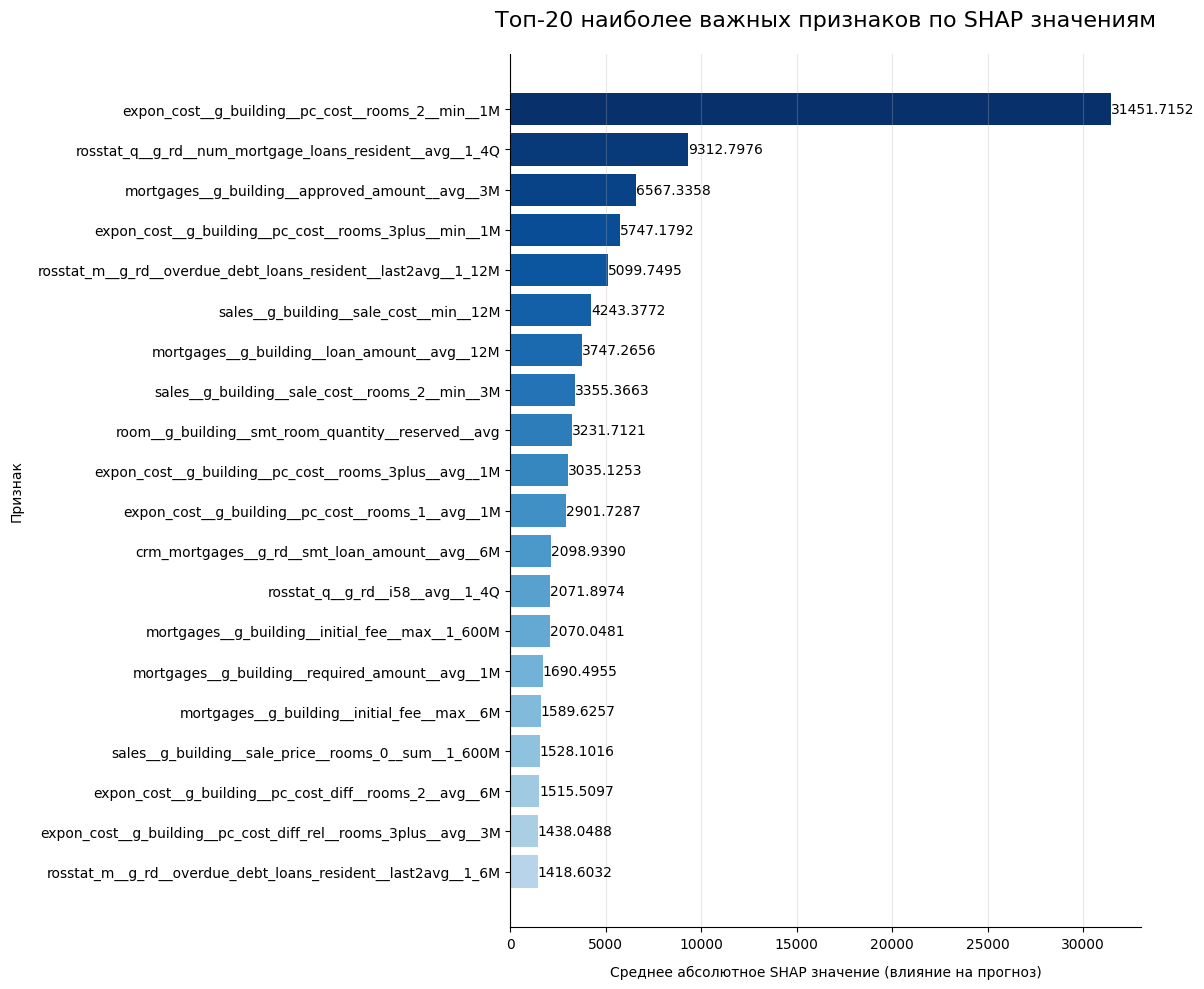

In [28]:
# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –∏ —Ä–∞—Å—á–µ—Ç SHAP –∑–Ω–∞—á–µ–Ω–∏–π
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# –°–æ–∑–¥–∞–µ–º DataFrame —Å –≤–∞–∂–Ω–æ—Å—Ç—å—é —Ñ–∏—á
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False).head(20)

# –°—Ç–∏–ª–∏–∑–∞—Ü–∏—è –≥—Ä–∞—Ñ–∏–∫–∞
plt.figure(figsize=(12, 10))

# –ì–æ—Ä–∏–∑–æ–Ω—Ç–∞–ª—å–Ω—ã–π bar plot —Å —Ü–≤–µ—Ç–æ–≤–æ–π –≥—Ä–∞–¥–∞—Ü–∏–µ–π
colors = plt.cm.Blues(np.linspace(0.3, 1, len(shap_importance)))
bars = plt.barh(shap_importance['feature'][::-1], 
                shap_importance['importance'][::-1],
                color=colors)

# –î–æ–±–∞–≤–ª—è–µ–º –∑–Ω–∞—á–µ–Ω–∏—è –Ω–∞ –≥—Ä–∞—Ñ–∏–∫
for bar in bars:
    width = bar.get_width()
    plt.text(width, 
             bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', 
             ha='left', 
             va='center')

# –ù–∞—Å—Ç—Ä–æ–π–∫–∏ –≤–Ω–µ—à–Ω–µ–≥–æ –≤–∏–¥–∞
plt.title('–¢–æ–ø-20 –Ω–∞–∏–±–æ–ª–µ–µ –≤–∞–∂–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ SHAP –∑–Ω–∞—á–µ–Ω–∏—è–º', pad=20, fontsize=16)
plt.xlabel('–°—Ä–µ–¥–Ω–µ–µ –∞–±—Å–æ–ª—é—Ç–Ω–æ–µ SHAP –∑–Ω–∞—á–µ–Ω–∏–µ (–≤–ª–∏—è–Ω–∏–µ –Ω–∞ –ø—Ä–æ–≥–Ω–æ–∑)', labelpad=10)
plt.ylabel('–ü—Ä–∏–∑–Ω–∞–∫', labelpad=10)
plt.grid(axis='x', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


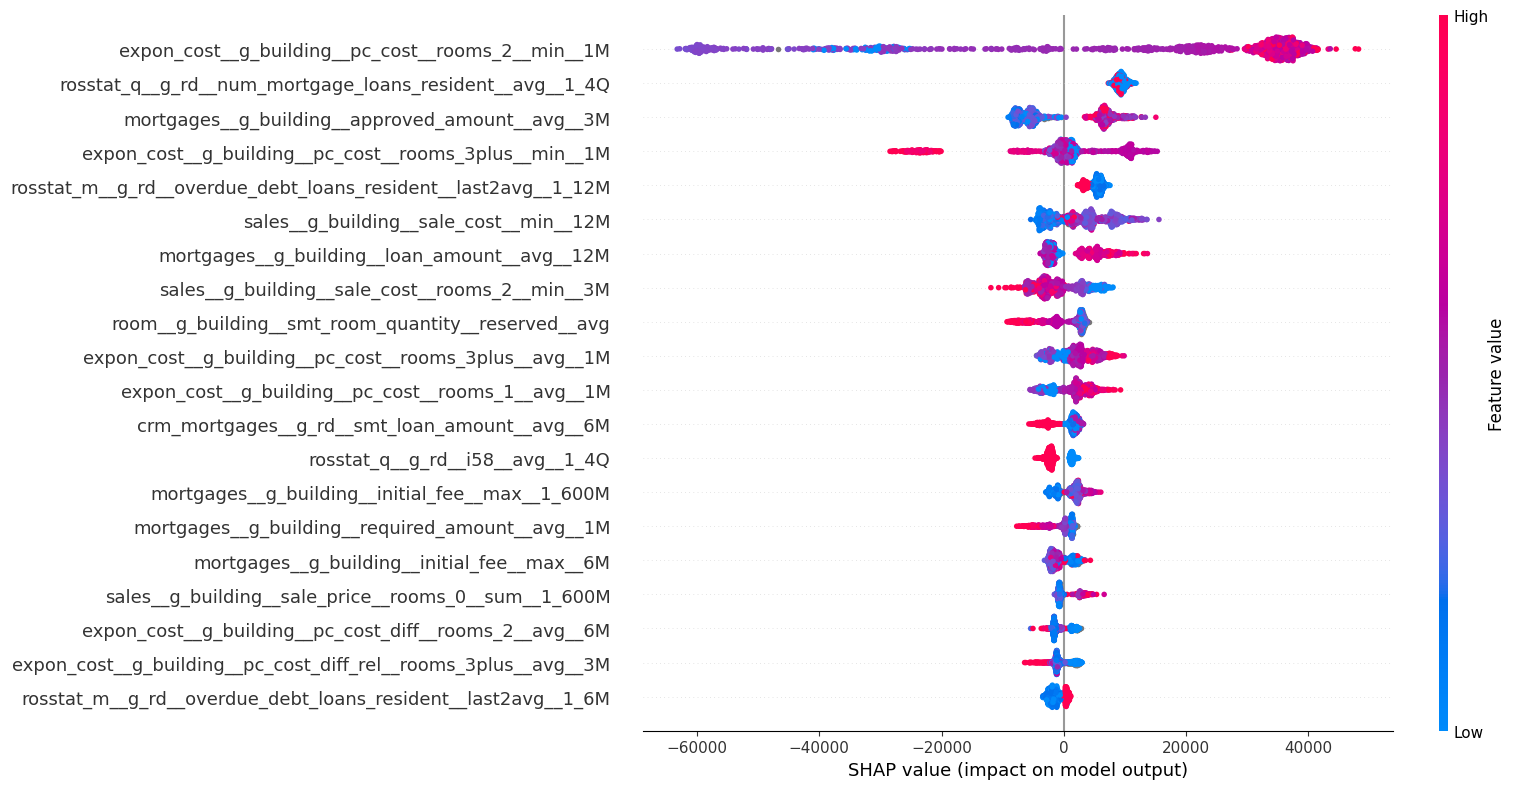

In [29]:
shap_gr(model, X_test)

# OPTUNA

In [30]:
# –†–∞–∑–¥–µ–ª—è–µ–º –¥–∞–Ω–Ω—ã–µ
train_data = filtered_df[filtered_df['split_type'] == 'train']
test_data = filtered_df[filtered_df['split_type'] == 'oot']

X_train_full = train_data.drop(columns=['split_type', 'smt_building_addressid', 'report_date',target_])
y_train_full = train_data[target_]

X_test = test_data.drop(columns=['split_type', 'smt_building_addressid', 'report_date', target_])
y_test = test_data[target_]

# –î–µ–ª–∏–º —á–∞—Å—Ç—å train –Ω–∞ train/valid –¥–ª—è Optuna
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, 
                                                    test_size=0.2, random_state=42)

# –î–ª—è CatBoost –Ω—É–∂–Ω–æ —É–∫–∞–∑—ã–≤–∞—Ç—å cat_features
cat_features = ['year_month'] if 'year_month' in X_train.columns else []

# –£–ª—É—á—à–µ–Ω–Ω–∞—è –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è —á–µ—Ä–µ–∑ Optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 1000, 3000),
        "depth": trial.suggest_int("depth", 4, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 0.1, 3.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "loss_function": "MAE",
        "early_stopping_rounds": 100,
        "verbose": False,
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Lossguide", "Depthwise"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }

    # –î–æ–±–∞–≤–ª—è–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç —Ç–∏–ø–∞ –±—É—Ç—Å—Ç—Ä–∞–ø–∞
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 10.0)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 1.0)

    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), 
             cat_features=cat_features, early_stopping_rounds=100, verbose=0)
    
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

# –£–ª—É—á—à–µ–Ω–Ω—ã–π –∑–∞–ø—É—Å–∫ Optuna
study = optuna.create_study(direction="minimize",
                          sampler=optuna.samplers.TPESampler(seed=42),
                          pruner=optuna.pruners.HyperbandPruner())

study.optimize(objective, n_trials=30)  

print("–õ—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

# –û–±—É—á–∞–µ–º —Ñ–∏–Ω–∞–ª—å–Ω—É—é –º–æ–¥–µ–ª—å —Å –ª—É—á—à–∏–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
best_params = study.best_params.copy()
best_params.update({
    "loss_function": "MAE",
    "early_stopping_rounds": 100,
    "verbose": 100,
    "task_type": "CPU",  
})

# –£–¥–∞–ª—è–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã, –∫–æ—Ç–æ—Ä—ã–µ –Ω–µ –Ω—É–∂–Ω—ã –≤ —Ñ–∏–Ω–∞–ª—å–Ω–æ–π –º–æ–¥–µ–ª–∏
for param in ['iterations', 'early_stopping_rounds']:
    if param in best_params:
        del best_params[param]

final_model = CatBoostRegressor(**best_params)
final_model.fit(X_train_full, y_train_full,
               cat_features=cat_features,
               early_stopping_rounds=100,
               verbose=100)

# –î–µ–ª–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è 
train_pred = final_model.predict(X_train_full)
test_pred = final_model.predict(X_test)

# –°–æ–∑–¥–∞–µ–º DataFrame —Å –º–µ—Ç—Ä–∏–∫–∞–º–∏
metrics_df = pd.DataFrame([
    calculate_metrics(y_train_full, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
metrics_df_optuna = metrics_df

[I 2025-05-19 23:24:16,688] A new study created in memory with name: no-name-e178df48-dc63-427e-a5d8-74098a402b15
[I 2025-05-19 23:24:21,272] Trial 0 finished with value: 11079.694221679378 and parameters: {'iterations': 1749, 'depth': 8, 'learning_rate': 0.029106359131330698, 'l2_leaf_reg': 0.24810409748678114, 'random_strength': 0.5524540572830658, 'border_count': 66, 'min_data_in_leaf': 6, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6061695553391381}. Best is trial 0 with value: 11079.694221679378.
[I 2025-05-19 23:24:23,312] Trial 1 finished with value: 12812.850706228233 and parameters: {'iterations': 1363, 'depth': 4, 'learning_rate': 0.004059611610484304, 'l2_leaf_reg': 0.12561043700013563, 'random_strength': 1.3526405540621358, 'border_count': 97, 'min_data_in_leaf': 62, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7571172192068059}. Best is trial 0 with value: 11079.694221679378.
[I 2025-05-19 23:24:26,181] Trial 2

–õ—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã:
iterations: 2005
depth: 8
learning_rate: 0.020469317534302804
l2_leaf_reg: 0.1486391322130916
random_strength: 0.3862697980288674
border_count: 102
min_data_in_leaf: 72
grow_policy: Depthwise
bootstrap_type: MVS
0:	learn: 35863.4002838	total: 6.1ms	remaining: 6.1s
100:	learn: 12891.0375233	total: 623ms	remaining: 5.54s
200:	learn: 9653.5974749	total: 1.17s	remaining: 4.63s
300:	learn: 8728.4106005	total: 1.65s	remaining: 3.83s
400:	learn: 8167.5900821	total: 2.1s	remaining: 3.14s
500:	learn: 7704.3953907	total: 2.56s	remaining: 2.55s
600:	learn: 7365.9129392	total: 3.01s	remaining: 2s
700:	learn: 7061.0749460	total: 3.49s	remaining: 1.49s
800:	learn: 6817.6199127	total: 3.97s	remaining: 988ms
900:	learn: 6631.8423854	total: 4.43s	remaining: 487ms
999:	learn: 6473.0974995	total: 4.88s	remaining: 0us


In [31]:
metrics_df_optuna

dataset           MAE           MSE          RMSE      MAPE      WAPE  \
0   train   6473.097464  2.012761e+08  14187.181868  0.034705  0.034860   
1    test  19550.730316  7.453694e+08  27301.453482  0.099563  0.096708   

         R2    mean_target      mean_pred  n_samples  
0  0.921343  185685.752829  185218.710787       5958  
1  0.787602  202162.258782  210184.100767       1129

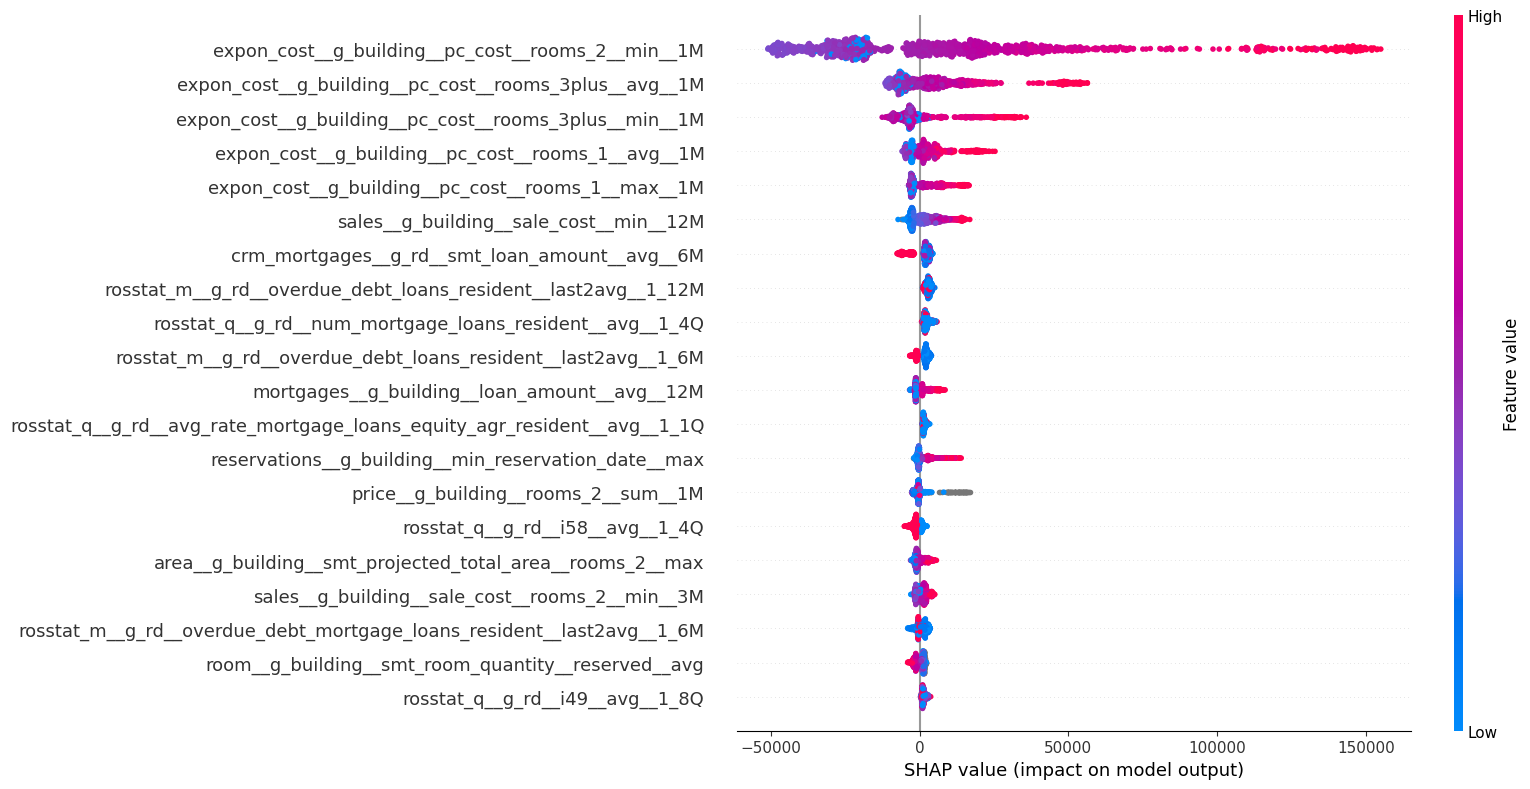

In [32]:
shap_gr(final_model, X_test)

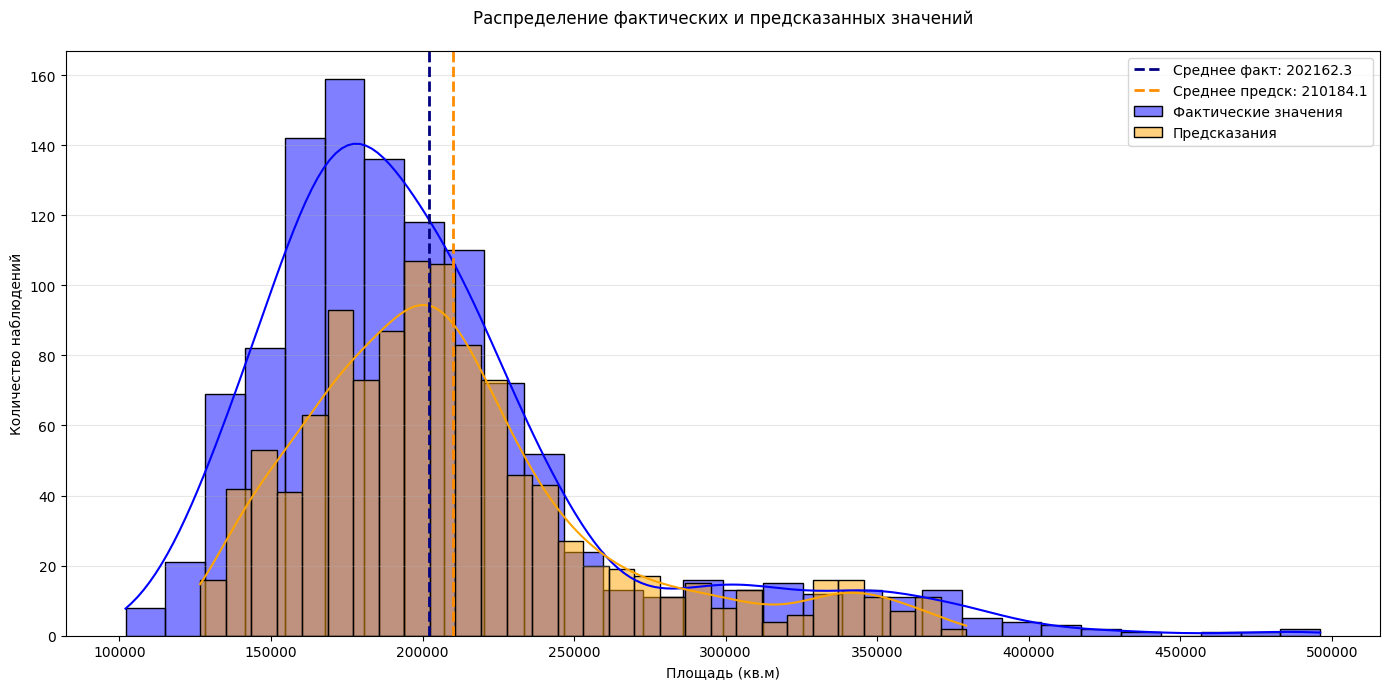

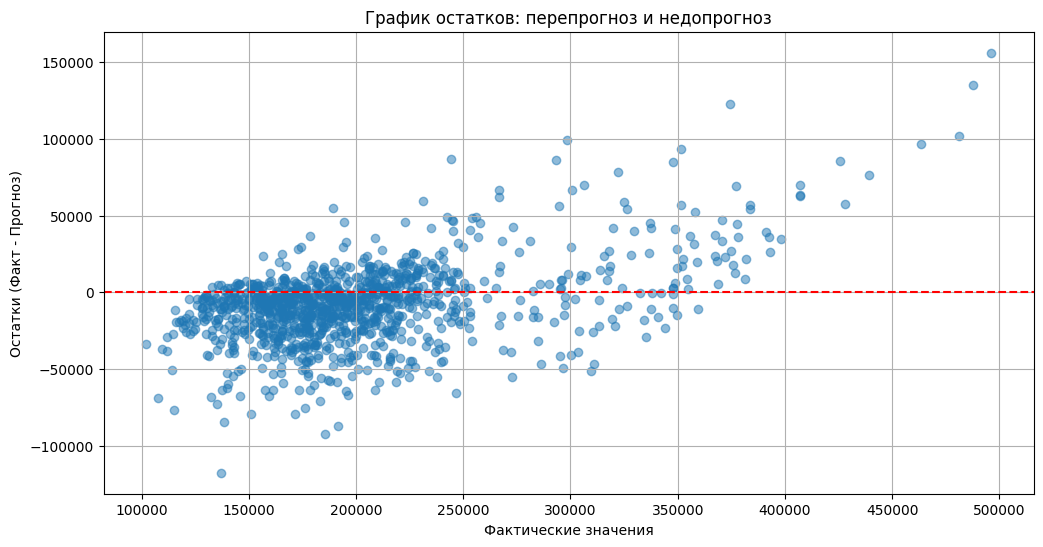

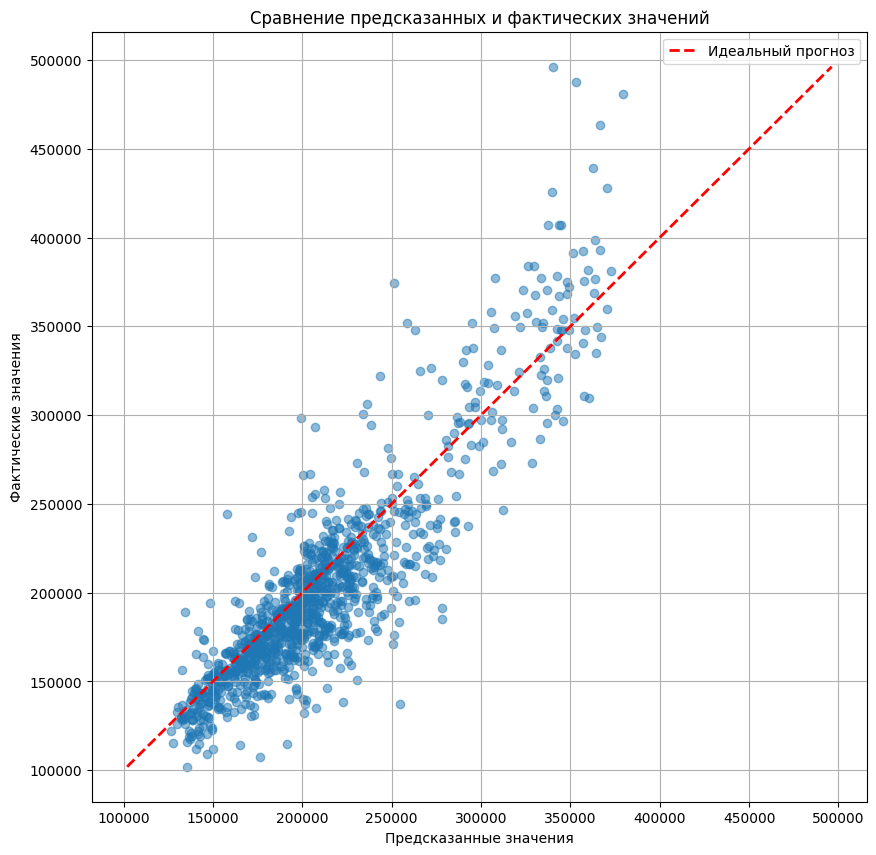

In [33]:
# 1. –ê–Ω–∞–ª–∏–∑ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ç–∞—Ä–≥–µ—Ç–∞ –∏ –ø—Ä–µ–¥–∏–∫—Ç–æ–≤
plt.figure(figsize=(14, 7))

# –ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ —Å –Ω–∞–ª–æ–∂–µ–Ω–∏–µ–º KDE
ax = sns.histplot(y_test, bins=30, color='blue', alpha=0.5, label='–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è', kde=True)
sns.histplot(test_pred, bins=30, color='orange', alpha=0.5, label='–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è', kde=True, ax=ax)

# –î–æ–±–∞–≤–ª—è–µ–º –ª–∏–Ω–∏–∏ —Å—Ä–µ–¥–Ω–∏—Ö
plt.axvline(y_test.mean(), color='navy', linestyle='--', linewidth=2, label=f'–°—Ä–µ–¥–Ω–µ–µ —Ñ–∞–∫—Ç: {y_test.mean():.1f}')
plt.axvline(test_pred.mean(), color='darkorange', linestyle='--', linewidth=2, label=f'–°—Ä–µ–¥–Ω–µ–µ –ø—Ä–µ–¥—Å–∫: {test_pred.mean():.1f}')

plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ñ–∞–∫—Ç–∏—á–µ—Å–∫–∏—Ö –∏ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π', pad=20)
plt.xlabel('–ü–ª–æ—â–∞–¥—å (–∫–≤.–º)')
plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–±–ª—é–¥–µ–Ω–∏–π')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. –ì—Ä–∞—Ñ–∏–∫ –ø–µ—Ä–µ–ø—Ä–æ–≥–Ω–æ–∑–∞/–Ω–µ–¥–æ–ø—Ä–æ–≥–Ω–æ–∑–∞
residuals = y_test - test_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('–ì—Ä–∞—Ñ–∏–∫ –æ—Å—Ç–∞—Ç–∫–æ–≤: –ø–µ—Ä–µ–ø—Ä–æ–≥–Ω–æ–∑ –∏ –Ω–µ–¥–æ–ø—Ä–æ–≥–Ω–æ–∑')
plt.xlabel('–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.ylabel('–û—Å—Ç–∞—Ç–∫–∏ (–§–∞–∫—Ç - –ü—Ä–æ–≥–Ω–æ–∑)')
plt.grid()
plt.show()

# 3. –°–∫—ç—Ç—Ç–µ—Ä–ø–ª–æ—Ç —Å –¥–∏–∞–≥–æ–Ω–∞–ª—å–Ω–æ–π –ª–∏–Ω–∏–µ–π
plt.figure(figsize=(10, 10))
plt.scatter(test_pred, y_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', linewidth=2, label='–ò–¥–µ–∞–ª—å–Ω—ã–π –ø—Ä–æ–≥–Ω–æ–∑')
plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã—Ö –∏ —Ñ–∞–∫—Ç–∏—á–µ—Å–∫–∏—Ö –∑–Ω–∞—á–µ–Ω–∏–π')
plt.xlabel('–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.ylabel('–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.legend()
plt.grid()
plt.show()


In [34]:
metrics_df_base.insert(0, 'stage', '–ë–∞–∑–æ–≤–∞—è –º–æ–¥–µ–ª—å')
metrics_df_with_select_features.insert(0, 'stage', '–ú–æ–¥–µ–ª—å —Å –æ—Ç–±–æ—Ä–æ–º –ø—Ä–∏–∑–Ω–∞–∫–æ–≤')
metrics_df_optuna.insert(0, 'stage', '–û–ø—Ç–∏–º–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è –º–æ–¥–µ–ª—å (Optuna)')

In [35]:
result = pd.concat([metrics_df_base,metrics_df_with_select_features,metrics_df_optuna], ignore_index=True)
result

stage dataset           MAE           MSE  \
0                    –ë–∞–∑–æ–≤–∞—è –º–æ–¥–µ–ª—å   train   1865.386966  3.186300e+07   
1                    –ë–∞–∑–æ–≤–∞—è –º–æ–¥–µ–ª—å    test  19883.296825  8.057114e+08   
2        –ú–æ–¥–µ–ª—å —Å –æ—Ç–±–æ—Ä–æ–º –ø—Ä–∏–∑–Ω–∞–∫–æ–≤   train   4108.449239  1.171805e+08   
3        –ú–æ–¥–µ–ª—å —Å –æ—Ç–±–æ—Ä–æ–º –ø—Ä–∏–∑–Ω–∞–∫–æ–≤    test  19813.401604  7.365610e+08   
4  –û–ø—Ç–∏–º–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è –º–æ–¥–µ–ª—å (Optuna)   train   6473.097464  2.012761e+08   
5  –û–ø—Ç–∏–º–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è –º–æ–¥–µ–ª—å (Optuna)    test  19550.730316  7.453694e+08   

           RMSE      MAPE      WAPE        R2    mean_target      mean_pred  \
0   5644.731817  0.010823  0.010046  0.987548  185685.752829  185366.093812   
1  28385.056469  0.098025  0.098353  0.770408  202162.258782  204964.810006   
2  10824.993241  0.023166  0.022126  0.954207  185685.752829  185473.345168   
3  27139.657440  0.102124  0.098007  0.790112  202162.258782  211229.126685   
4  14187.181868  0.034705  0.034860  0.921343  185685.752829  185218.710787   
5  27301.453482  0.099563  0.096708  0.787602  202162.258782  210184.100767   

   n_samples  
0       5958  
1       1129  
2       5958  
3       1129  
4       5958  
5       1129

In [36]:
# –°–æ—Ö—Ä–∞–Ω—è–µ–º –º–æ–¥–µ–ª—å
with open('model_cost.pkl', 'wb') as f:
    pickle.dump(final_model, f)